In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from Bio.Seq import Seq
from Bio import motifs
import random

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D

import sklearn
from sklearn.linear_model import LogisticRegression

%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'

Using TensorFlow backend.


## Data And Model Setup

In [83]:
def train_model(x, y, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model


def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))   #LAE: .values added, pd deprecation
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df

def test_binary_data(df, model, test_seq, obs_col, output_col='pred'):
    # No need to reshape since values already are all 0 or 1
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = predictions
    return df


def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

In [3]:
#df = pd.read_pickle('../data/egfp_unmod_1.pkl')  #LAE: do not have this pickle file...?
df = pd.read_csv('../data/egfp_unmod_1.csv',index_col=0)
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df.iloc[:20000]
e_train = df.iloc[20000:]

# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

# Scale the training mean ribosome load values
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

# Label the datasets
e_train.loc[:,'dataset'] = 'train'
e_test.loc[:,'dataset'] = 'test'

label_e_train = e_train['rl'].values
label_e_test = e_test['rl'].values

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Create and Train Models

In [4]:
# Load Saved Model
model = keras.models.load_model('./saved_models/main_MRL_model.hdf5') #this is the Author's model

W0916 11:20:40.442754 4431926720 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0916 11:20:40.457848 4431926720 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0916 11:20:40.460922 4431926720 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0916 11:20:40.547632 4431926720 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0916 11:20:40.556330 4431926720 deprecati

In [5]:
e_train = test_data(df=e_train,model=model,test_seq=seq_e_train,obs_col='rl',output_col='auth_pred')
e_test = test_data(df=e_test,model=model,test_seq=seq_e_test,obs_col='rl',output_col='auth_pred')

## Visualize Results

In [6]:
def jointgrid_plot(datasets,one_dataset=False,colors=[(0.3, 0.45, 0.69),'r'],title="",alphas=[0.1,0.1],
                   xheader='rl',yheader='pred'):
    """
    Make a jointgrid scatter plot of Observed MRL vs Predicted MRL using two or more different datasets 
    colored according to the input list of colors, in a style like the author's figure. 
    If only one dataset, set the flag one_dataset to True so that datasets can be of type list without 
    getting datasets vs dataset elements confused. Bad code but hey.
    """
    data = datasets if one_dataset == True else datasets[0]
    
    g = sns.JointGrid(x=xheader, y=yheader, data=data, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
    g.plot_joint(plt.scatter,s=20, color=colors[0], linewidth=0.2, alpha=str(alphas[0]), edgecolor='white')
    f = g.fig
    ax = f.gca()
    ax.set_yticks(np.arange(0,9.01, 1));
    ax.set_yticklabels(range(10),size=20);
    ax.set_xticks(np.arange(1,10.01, 1));
    ax.set_xticklabels(range(1,11),size=20);
    ax.set_ylim(0,9)
    ax.set_xlim(1,10)
    g.plot_marginals(sns.kdeplot,shade=colors[0], **{'linewidth':2, 'color':colors[0]})
    g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

    if one_dataset == False:
        alphas = alphas if len(alphas) == len(datasets) else [alphas[0]]*len(datasets)
        for d,c,a in zip(datasets[1:],colors[1:],alphas[1:]):
            g.x = d[xheader].values
            g.y = d[yheader].values
            g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha=str(a), color=c, edgecolor='white')
            g.plot_marginals(sns.kdeplot, shade=c, **{'linewidth':2, 'color':c})
            f = g.fig

    f.suptitle(title,fontsize=20)
    
    return f

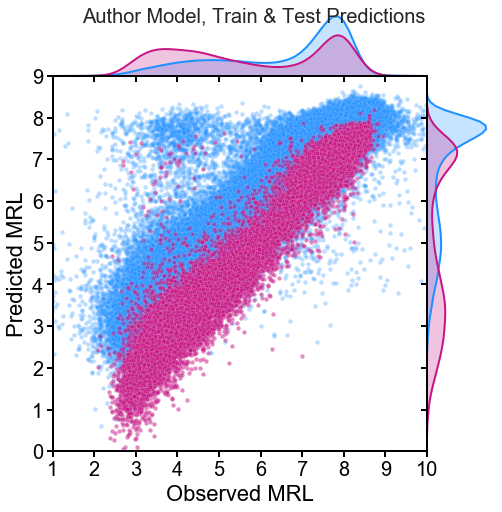

In [123]:
plot_auth = jointgrid_plot([e_train,e_test],alphas=[0.3,0.5],yheader='auth_pred',colors=['dodgerblue','mediumvioletred'],
                           title="Author Model, Train & Test Predictions")

In [27]:
# Combine Datasets so that we can split on different concepts
data = pd.concat([e_train,e_test],axis=0,sort=True)
data.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(data.loc[:,'rl'].values.reshape(-1,1))

In [35]:
# Isolate that off-diagonal "cluster" of low observed/high predicted MRL (Generous boundaries)
ofd = data[((data['auth_pred']-data['rl'])**2 > 3.5)
                  &(data['auth_pred']-data['rl'] > 0)
                  &(data['auth_pred'] > 6.5)] 
ond = data[~data['utr'].isin(ofd['utr'].values)]
print len(ofd), len(ond)
data.loc[:,'off_diagonal'] = [ s in ofd['utr'].values for s in data['utr'].values ]

1281 278719


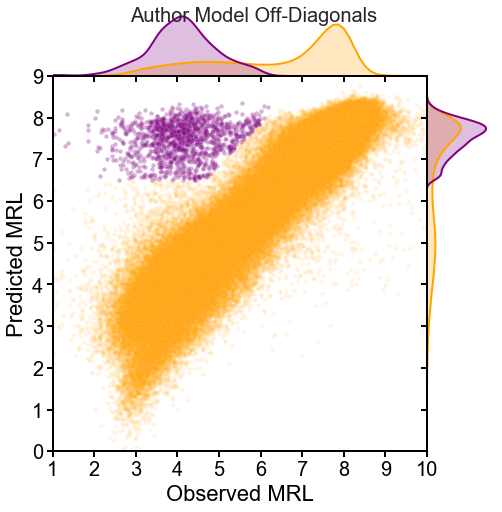

In [36]:
plot_auth2 = jointgrid_plot([ond,ofd],alphas=[0.1,0.3],yheader='auth_pred',
                            colors = ['orange','purple'],
                            title="Author Model Off-Diagonals")

## Goal: To Create a Model that Predicts Off-Diagonal Cluster Membership

- will require upsampling of the minority class (off-diagonal cluster elements), and maybe downsampling of majority class as well
- create both a smaller version of the main model that has no additional information, AND an alternate model that uses derived filter information and other info like MFE and read count

In [105]:
def count_results(df,xheader,yheader):
    d = { "true_pos":0,"true_neg":0,"false_pos":0,"false_neg":0, "total":0 }
    labels = df[xheader].values
    predictions = df[yheader].values
    d['total'] = len(labels)
    for l,p in zip(labels,predictions):
        if l == 1: # is truly pos
            if p == l:
                d['true_pos'] += 1
            else:
                d['false_neg'] += 1
        elif l == 0: # is truly neg
            if p == l:
                d['true_neg'] += 1
            else:
                d['false_pos'] += 1
        else:
            print "label not recognized"
            return 
    return d

In [ ]:
# Create Test and Train Sets

ofd.sort_values('total_reads', inplace=True, ascending=False)
ofd.reset_index(inplace=True, drop=True)
ond.sort_values('total_reads', inplace=True, ascending=False)
ond.reset_index(inplace=True, drop=True)

ofd.loc[:,'off_diagonal'] = 1
ond.loc[:,'off_diagonal'] = 0

In [56]:
# Test set does not really need to be balanced, 
# if we be sure to also performance on the off-diagonal UTRs set specifically
X_test = pd.concat([ ofd[:281],ond[:19719]], axis=0, sort=True)
X_test_minority = X_test[:281]

# Train set DOES need to be balanced, however. 
# 200k seqences in total:
#     100k of 1k off-diagonals upsampled 100x
#     100k of 50k high-read-count on-diagonals + 50k low-read-count on-diagonals
X_train = pd.concat( [ pd.concat([ofd[281:]]*100), ond[19719:69719], ond[-50000:] ], axis=0, sort=True)

In [57]:
# Shuffle order of Train Set
np.random.seed(42)
X_train = X_train.sample(frac=1)

X_train_seq = one_hot_encode(X_train)
X_test_seq = one_hot_encode(X_test)
X_test_minority_seq = X_test_seq[:281]

y_train = X_train['off_diagonal'].values
y_test = X_test['off_diagonal'].values

In [108]:
# Build the Smaller Model 
small_model = Sequential()
small_model.add(Conv1D(activation="relu", input_shape=(50, 4), padding="same",
                       filters=10, kernel_size=8))
small_model.add(Conv1D(activation="relu", input_shape=(50, 1), padding="same",
                       filters=10, kernel_size=8))
# small_model.add(Conv1D(activation="relu", input_shape=(50, 1), padding="same",
#                        filters=10, kernel_size=8))
small_model.add(Flatten())
small_model.add(Dense(30))
small_model.add(Activation('relu'))
small_model.add(Dropout(0.1))
small_model.add(Dense(1))
small_model.add(Activation('sigmoid')) #sigmoid to output a binary classification btw 0 (on-diagonal) and 1 (off)

In [109]:
# Compile and Train the Smaller Model
np.random.seed(1337)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
small_model.compile(loss='mean_squared_error', optimizer=adam)

small_model.fit(X_train_seq, y_train, batch_size=125, epochs=2, verbose=1) 
#changed batch size 128 -> 125 for even split

Epoch 1/2
200000/200000 [==============================] - 9s 46us/step - loss: 0.1302
Epoch 2/2
200000/200000 [==============================] - 8s 41us/step - loss: 0.0389


In [110]:
X_test = test_binary_data(df=X_test,model=small_model,test_seq=X_test_seq,obs_col='off_diagonal',output_col='small_pred')
X_test_minority = test_binary_data(df=X_test_minority,model=small_model,
                            test_seq=X_test_minority_seq,obs_col='off_diagonal',output_col='small_pred_min')

In [111]:
rd = count_results(X_test,'off_diagonal','small_pred')
print "% correct", 100 * (rd['true_pos']+rd['true_neg']) / rd['total']

% correct 0


In [112]:
rd = count_results(X_test_minority,'off_diagonal','small_pred_min')
print "% correct", 100 * (rd['true_pos']+rd['true_neg']) / rd['total']

% correct 0


#### Uhh...I don't know why this is 0% accurancy, since that's actually the same as 100% accuracy? Why is it flipped?